# Belgium Taffic Sign Dataset

## 1. CARGA DE DATOS

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import math
from tensorflow.contrib import layers
import time

# Allow image embeding in notebook
%matplotlib inline

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_data(data_dir, width, height):
    directories = [d for d in os.listdir(data_dir) 
                 if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            labels.append(int(d))
            images.append(skimage.transform.resize(skimage.data.imread(f), (width, height)))
    
    labels=np.array(labels)
    images=np.array(images)
    
    return images, labels

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_data(test_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Model 2: Leaky-ReLU & Minibatches

In [5]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [6]:
class Model2():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,62, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [7]:
def evaluate(model, images, labels, imprimir=True):
    #Run predictions against the full test set
    #print(images.shape)
    #print(labels.shape)
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]

    return loss, accuracy  

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs_test=[]
    acc_test=[]
    costs_train=[]
    acc_train=[]
    for i in range(train_counts):
        if i % 10 == 0:
            loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
            costs_test.append(loss_test)
            acc_test.append(accuracy_test)
            loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
            costs_train.append(loss_train)
            acc_train.append(accuracy_train)
            a = model.session.run(model.global_step)
            if imprimir == True:
                print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
                print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
        # ??? improve picking batches

        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    
    loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(acc_train), label='Entr.')
        plt.plot(np.squeeze(acc_test), label='Valid.')
        plt.ylabel('Precisión')
        plt.xlabel('Iteraciones por decenas')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
        plt.plot(np.squeeze(costs_test), label='Test')
        plt.ylabel('Coste')
        plt.xlabel('iteraciones por decenas')
        plt.show()
    
    return costs_train, acc_train, costs_test, acc_test
        
        

   0, Loss: 4.245  Train accuracy: 0.012
   0, Loss: 4.185  Test accuracy: 0.026
  10, Loss: 3.487  Train accuracy: 0.218
  10, Loss: 3.495  Test accuracy: 0.238
  20, Loss: 3.161  Train accuracy: 0.343
  20, Loss: 3.204  Test accuracy: 0.357
  30, Loss: 2.805  Train accuracy: 0.434
  30, Loss: 2.962  Test accuracy: 0.402
  40, Loss: 2.613  Train accuracy: 0.463
  40, Loss: 2.842  Test accuracy: 0.416
  50, Loss: 2.336  Train accuracy: 0.555
  50, Loss: 2.564  Test accuracy: 0.496
  60, Loss: 2.205  Train accuracy: 0.563
  60, Loss: 2.394  Test accuracy: 0.547
  70, Loss: 2.061  Train accuracy: 0.628
  70, Loss: 2.328  Test accuracy: 0.533
  80, Loss: 1.985  Train accuracy: 0.645
  80, Loss: 2.320  Test accuracy: 0.535
  90, Loss: 1.978  Train accuracy: 0.634
  90, Loss: 2.163  Test accuracy: 0.571
 100, Loss: 1.884  Train accuracy: 0.644
 100, Loss: 2.096  Test accuracy: 0.566
 110, Loss: 1.794  Train accuracy: 0.657
 110, Loss: 2.091  Test accuracy: 0.577
 120, Loss: 1.708  Train acc

1020, Loss: 0.237  Train accuracy: 0.970
1020, Loss: 0.543  Test accuracy: 0.882
1030, Loss: 0.284  Train accuracy: 0.963
1030, Loss: 0.598  Test accuracy: 0.881
1040, Loss: 0.270  Train accuracy: 0.964
1040, Loss: 0.574  Test accuracy: 0.879
1050, Loss: 0.280  Train accuracy: 0.961
1050, Loss: 0.651  Test accuracy: 0.859
1060, Loss: 0.262  Train accuracy: 0.969
1060, Loss: 0.583  Test accuracy: 0.873
1070, Loss: 0.262  Train accuracy: 0.967
1070, Loss: 0.566  Test accuracy: 0.890
1080, Loss: 0.249  Train accuracy: 0.973
1080, Loss: 0.579  Test accuracy: 0.883
1090, Loss: 0.248  Train accuracy: 0.973
1090, Loss: 0.584  Test accuracy: 0.875
1100, Loss: 0.244  Train accuracy: 0.973
1100, Loss: 0.564  Test accuracy: 0.883
1110, Loss: 0.237  Train accuracy: 0.972
1110, Loss: 0.534  Test accuracy: 0.892
1120, Loss: 0.245  Train accuracy: 0.969
1120, Loss: 0.583  Test accuracy: 0.872
1130, Loss: 0.236  Train accuracy: 0.972
1130, Loss: 0.570  Test accuracy: 0.881
1140, Loss: 0.235  Train acc

2040, Loss: 0.095  Train accuracy: 0.989
2040, Loss: 0.443  Test accuracy: 0.891
2050, Loss: 0.094  Train accuracy: 0.990
2050, Loss: 0.441  Test accuracy: 0.888
2060, Loss: 0.103  Train accuracy: 0.982
2060, Loss: 0.463  Test accuracy: 0.880
2070, Loss: 0.090  Train accuracy: 0.990
2070, Loss: 0.409  Test accuracy: 0.900
2080, Loss: 0.097  Train accuracy: 0.990
2080, Loss: 0.465  Test accuracy: 0.890
2090, Loss: 0.094  Train accuracy: 0.989
2090, Loss: 0.469  Test accuracy: 0.885
2100, Loss: 0.095  Train accuracy: 0.988
2100, Loss: 0.462  Test accuracy: 0.894
2110, Loss: 0.116  Train accuracy: 0.980
2110, Loss: 0.479  Test accuracy: 0.886
2120, Loss: 0.101  Train accuracy: 0.987
2120, Loss: 0.476  Test accuracy: 0.893
2130, Loss: 0.118  Train accuracy: 0.987
2130, Loss: 0.509  Test accuracy: 0.888
2140, Loss: 0.113  Train accuracy: 0.986
2140, Loss: 0.498  Test accuracy: 0.892
2150, Loss: 0.117  Train accuracy: 0.985
2150, Loss: 0.514  Test accuracy: 0.888
2160, Loss: 0.110  Train acc

3060, Loss: 0.041  Train accuracy: 0.997
3060, Loss: 0.411  Test accuracy: 0.890
3070, Loss: 0.041  Train accuracy: 0.995
3070, Loss: 0.414  Test accuracy: 0.894
3080, Loss: 0.041  Train accuracy: 0.997
3080, Loss: 0.385  Test accuracy: 0.900
3090, Loss: 0.044  Train accuracy: 0.994
3090, Loss: 0.407  Test accuracy: 0.900
3100, Loss: 0.042  Train accuracy: 0.995
3100, Loss: 0.406  Test accuracy: 0.897
3110, Loss: 0.040  Train accuracy: 0.996
3110, Loss: 0.389  Test accuracy: 0.900
3120, Loss: 0.041  Train accuracy: 0.996
3120, Loss: 0.406  Test accuracy: 0.891
3130, Loss: 0.041  Train accuracy: 0.996
3130, Loss: 0.393  Test accuracy: 0.892
3140, Loss: 0.037  Train accuracy: 0.996
3140, Loss: 0.359  Test accuracy: 0.908
3150, Loss: 0.041  Train accuracy: 0.997
3150, Loss: 0.404  Test accuracy: 0.888
3160, Loss: 0.042  Train accuracy: 0.995
3160, Loss: 0.410  Test accuracy: 0.890
3170, Loss: 0.039  Train accuracy: 0.997
3170, Loss: 0.371  Test accuracy: 0.901
3180, Loss: 0.036  Train acc

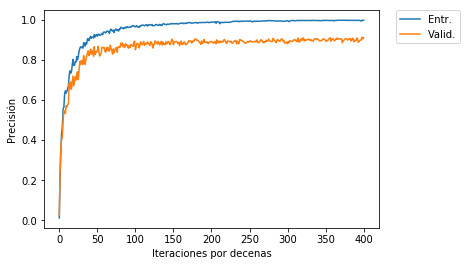

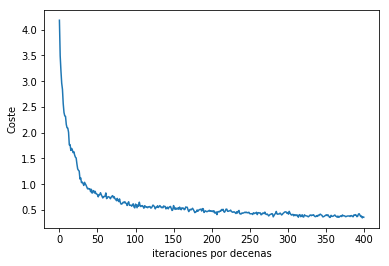

Tiemo de inicio 1537888744.996399
Tiemo de final 1537888836.8225465
Tiempo 91.83 s


In [12]:
t_start=time.time()

m2 = Model2()
modelo_2 = train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 4000)
t_fin=time.time()
print('Tiemo de inicio', t_start)
print('Tiemo de final', t_fin)
print('Tiempo', round(t_fin-t_start,2), 's')

In [86]:
for i in range(6):
    m2 = Model2()
    train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 4000, False)

4000, Loss: 0.029  Train accuracy: 0.996
4000, Loss: 0.400  Test accuracy: 0.893
4000, Loss: 0.024  Train accuracy: 0.997
4000, Loss: 0.390  Test accuracy: 0.901
4000, Loss: 0.029  Train accuracy: 0.996
4000, Loss: 0.369  Test accuracy: 0.911
4000, Loss: 0.027  Train accuracy: 0.997
4000, Loss: 0.402  Test accuracy: 0.900
4000, Loss: 0.027  Train accuracy: 0.997
4000, Loss: 0.402  Test accuracy: 0.901
4000, Loss: 0.025  Train accuracy: 0.998
4000, Loss: 0.438  Test accuracy: 0.888


Parece que ahora tenemos overfitting...

## 3. VISUALIZACIÓN DE LOS PESOS

In [13]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

def display_images(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 9)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]

In [14]:
#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]
label_exemplars =[]
for i in range(62):
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_exemplars.append(X_train_orig[w])
            break
#label_counts = [np.count_nonzero(X_train_orig ==l ) for l in range(62)]
label_counts = []
for i in range(62):
    label_counts.append(0)
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_counts[i] = label_counts[i]+1

In [15]:
# Loop trough the graph and print the names and shapes of all trainable variables
with m2.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 62)
fully_connected/biases:0 (62,)


In [16]:
#Get the values of the weight and bias variables.
m2_weights=m2.session.run("fully_connected/weights:0")
m2_biases=m2.session.run("fully_connected/biases:0")
print("weights shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m2_weights.shape, m2_weights.min(), m2_weights.max()))
print("biases shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m2_biases.shape, m2_biases.min(), m2_biases.max()))

weights shape: (3072, 62)    min: -0.5404    max: 0.5253
biases shape: (62,)         min: -0.1455    max: 0.4398


In [17]:
def display_weights(weights, limit):
    titles= ["Categoría {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
    images = list(zip(label_exemplars, weights.T.reshape(-1, 32, 32,3)))
    display_images(images[:limit], titles)

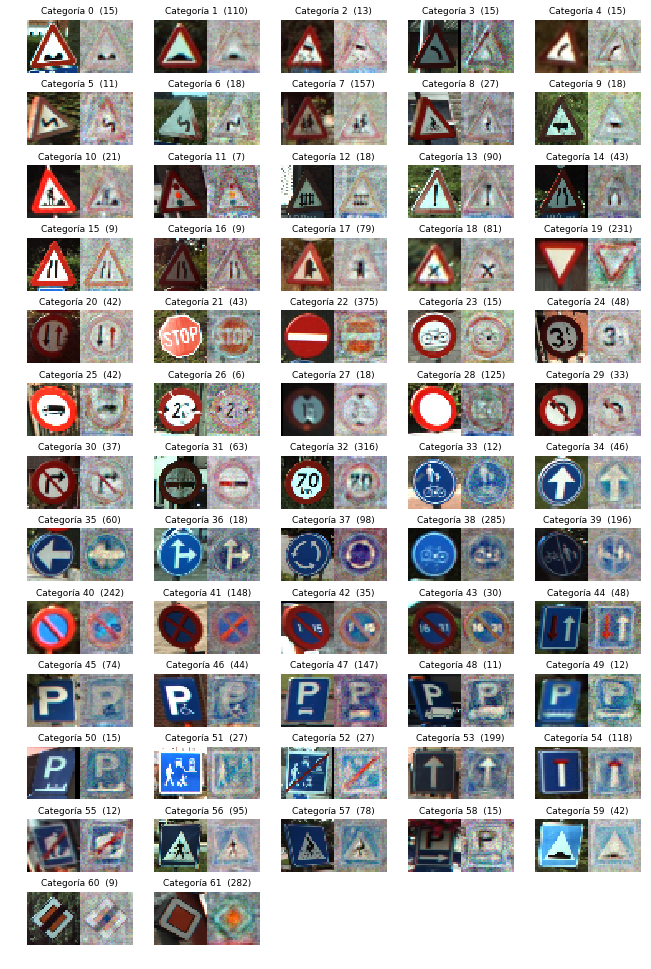

In [18]:
# Display weights of the first 30 labels
display_weights(m2_weights, 62)

In [19]:
def display_histograms(weights, title):
    cols = 5
    rows = math.ceil(len(weights[0])/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(weights[0]) is not np.ndarray else 1)
    plt.figure(figsize=(14,14 * 1))
    for i in range(len(weights[0])):
        plt.subplot(rows,cols,i+1)
        w = weights[:,i]
        plt.title(title[i], fontsize=8)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

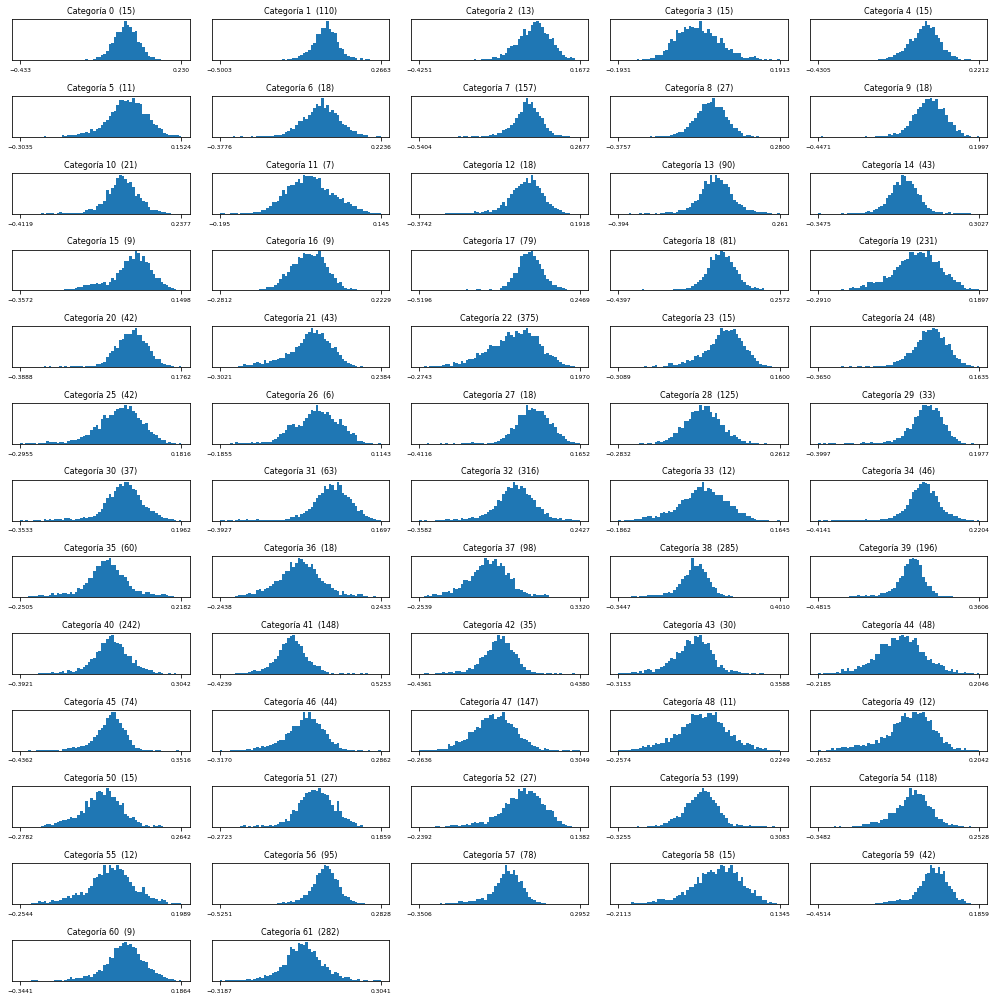

In [20]:
titles= ["Categoría {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
display_histograms(m2_weights, titles)

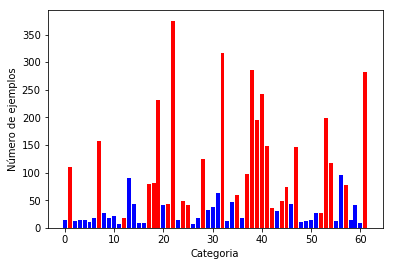

In [21]:
labels_count_x=list(range(62))
labels_count_y=label_counts
categorías_buenas = [1,7,12,17,18,19, 21,22,24,25,28,32,35,37,38,39,40,41,42,44,45,47,52,53,54,57,61]

colores = []
for i in range(62):
    colores.append('blue')
for i in categorías_buenas:
    colores[i]='red'


plt.bar(labels_count_x,labels_count_y,color=colores)
plt.xlabel('Categoria')
plt.ylabel('Número de ejemplos')
plt.show()

### Visualize the weights

Same as above. Let's see if the changes had any effect.

In [22]:
# Loop trough the graph and print the names and shapes of all trainable variables
with m2.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 62)
fully_connected/biases:0 (62,)


In [28]:
m2_weights = m2.session.run("fully_connected/weights:0")
m2_biases = m2.session.run("fully_connected/biases:0")
print("weights shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m2_weights.shape, m2_weights.min(), m2_weights.max()))
print("biases shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m2_biases.shape, m2_biases.min(), m2_biases.max()))

weights shape: (3072, 62)    min: -0.5404    max: 0.5253
biases shape: (62,)         min: -0.1455    max: 0.4398


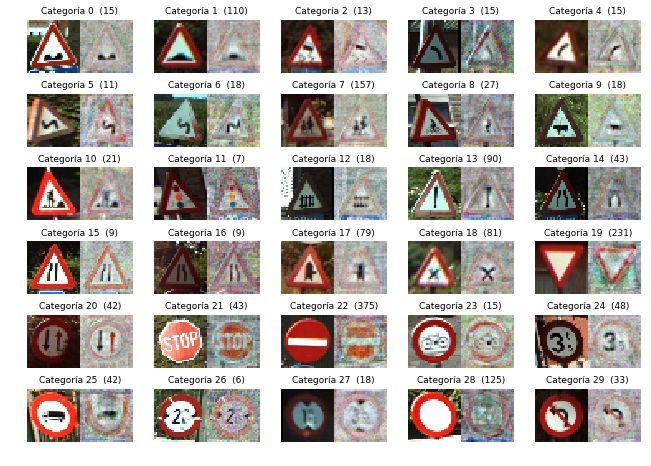

In [29]:
# Visualize weights of first 30 labels
display_weights(m2_weights, 30)

## CONFUSSION MATRIX

In [30]:
print(__doc__)

#import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Automatically created module for IPython interactive environment


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


53
51
Confusion matrix, without normalization
[[  0   6   0 ...   0   0   0]
 [  0  27   0 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   0 ...  14   0   0]
 [  0   0   0 ...   0   9   2]
 [  0   0   0 ...   0   0 105]]


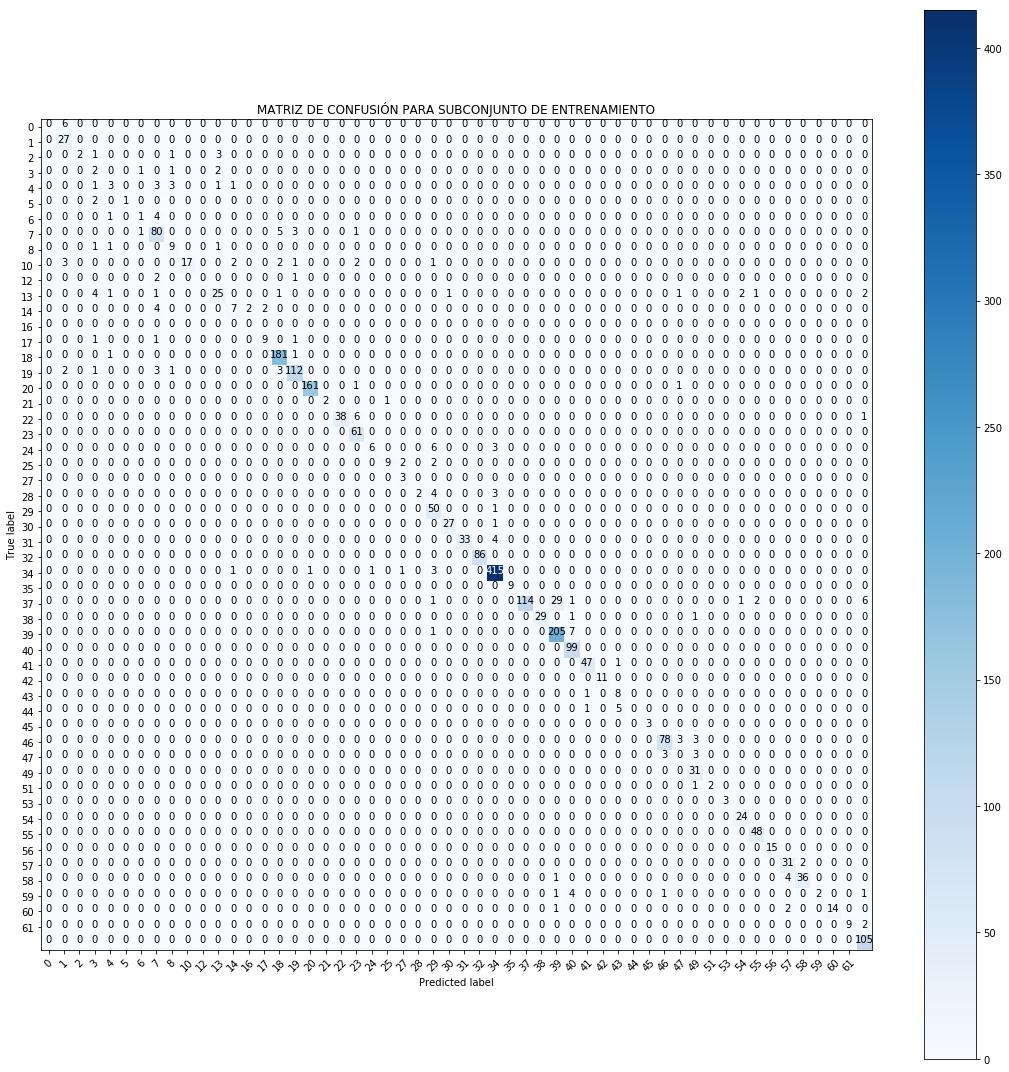

In [32]:
y_pred, _ = m2.session.run([m2.predicted_labels, m2.loss],
                                       {m2.images: X_test_orig, m2.labels:Y_test_orig})

y_test = Y_test_orig

#print(y_test)
#print(len(set(y_test)))
#print(y_pred)
print(len(set(y_test)))
print(len(set(y_pred)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names= list(set(Y_test_orig))

#Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='MATRIZ DE CONFUSIÓN PARA SUBCONJUNTO DE ENTRENAMIENTO')
#print(sum(sum(cnf_matrix)))
#print(cnf_matrix[53])
plt.show()

## ACIERTOS

In [62]:
label_count_test = []
cat_test = set(Y_test_orig)
i =0
for cat in cat_test:
    label_count_test.append(0)
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == cat:
            label_count_test[i] = label_count_test[i]+1
        
    i+=1
#print(sum(label_count_test))
#print(len(label_count_test))
#print(len(cat_test))
#print(cat_test)
#print(label_count_test[0])

In [63]:
pred_count_test = []
for i in range(63):
    pred_count_test.append(0)

In [64]:
y_pred, _ = m2.session.run([m2.predicted_labels, m2.loss],
                                       {m2.images: X_test_orig, m2.labels:Y_test_orig})
y_test = Y_test_orig

   
for i in range(2520):
    if y_pred[i]==y_test[i]:
        cat = y_test[i]
        #print(cat)
        pred_count_test[cat]=pred_count_test[cat]+1


#print(len(pred_count_test))
print(pred_count_test[1])
precision = []
i=0
for cat in cat_test:
    precision.append(pred_count_test[cat]/label_count_test[i]*100)
    i+=1
print(i)
prec = []
for preci in precision:
    prec.append(round(preci,2))

#print(y_pred)
#print(Y_test_orig)
#print(precision)
#print(len(pred_count_test))
#print(pred_count_test)
print(prec)

27
53
[16.67, 100.0, 14.29, 16.67, 16.67, 66.67, 50.0, 83.33, 91.67, 60.71, 0.0, 69.23, 60.0, 66.67, 98.36, 91.8, 96.93, 33.33, 91.11, 100.0, 40.0, 69.23, 100.0, 11.11, 100.0, 85.71, 89.19, 100.0, 98.58, 100.0, 67.53, 93.55, 92.96, 100.0, 100.0, 100.0, 66.67, 33.33, 100.0, 89.29, 0.0, 100.0, 33.33, 100.0, 100.0, 100.0, 100.0, 100.0, 73.17, 44.44, 82.35, 90.91, 100.0]


In [65]:
label_exemplars_test =[]
for cat in cat_test:
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_exemplars_test.append(X_test_orig[w])
            break
#len(label_exemplars_test)
#len(cat_test)

In [66]:
def display_aciertos(images, titles=None, cols=7, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(16,16 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 12)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [67]:
i=0
titles_aciertos=[]
for cat in cat_test:
    titles_aciertos.append("Cat. "+str(cat)+";  Pr.:"+str(prec[i])+'%')
    i +=1

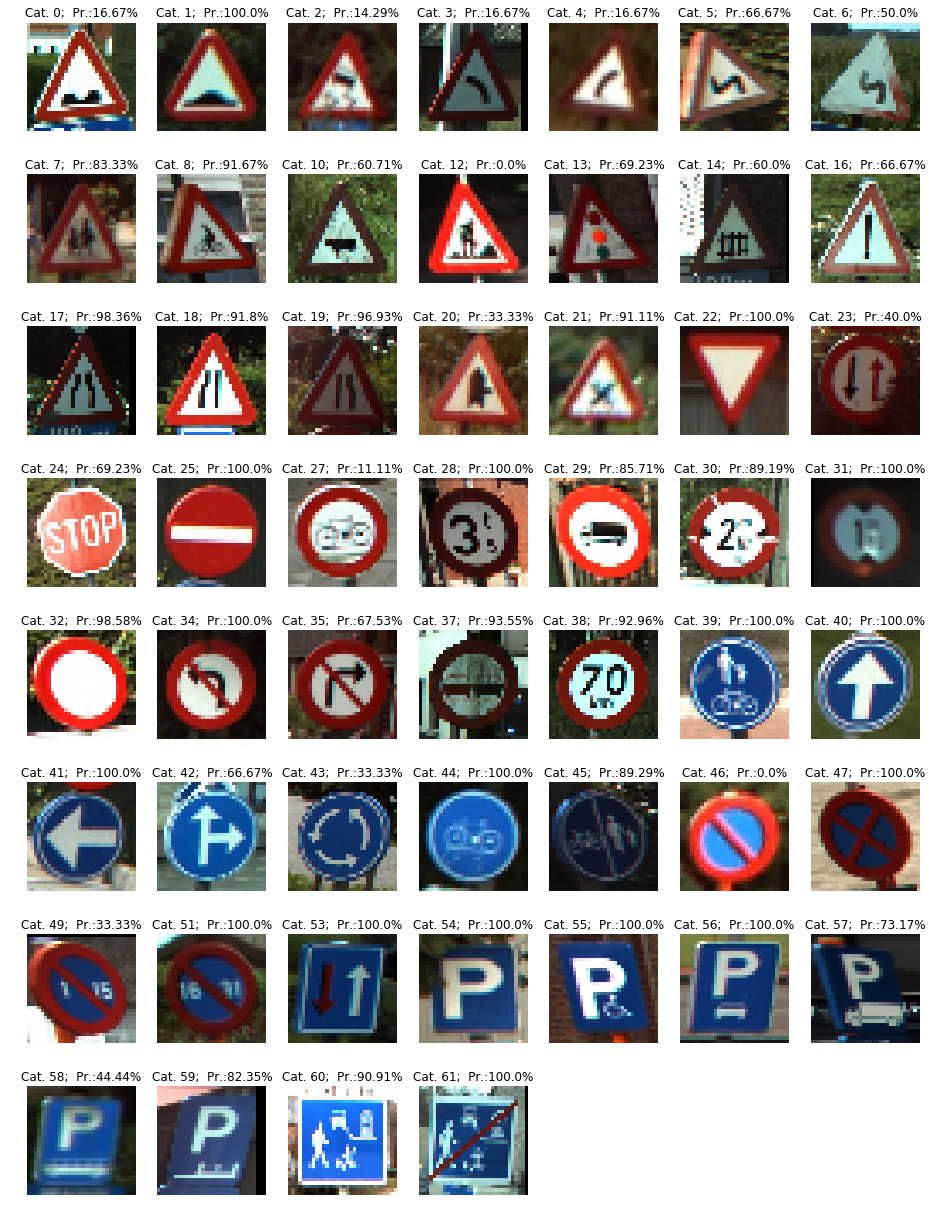

In [68]:
display_aciertos(label_exemplars, titles_aciertos)

In [69]:
cat_no_rep = [9, 11, 15, 26, 33, 36, 48, 50, 52]

titles_aciertos_hist=[]
#print(titles_aciertos_hist)
b=0
for i in range(62):
    a = 0
    #print('i',i)
    for cat in cat_no_rep:
        #print('cat',cat)
        if cat == i:
            titles_aciertos_hist.append('CAT. NO INCLUIDA')
            a = 1
            #print(a,'a')
            break
    if a == 0:
        titles_aciertos_hist.append(titles_aciertos[b]) 
        b+=1
    

In [70]:
def display_histograms_test(weights, title):
    cols = 5
    rows = math.ceil(len(weights[0])/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(weights[0]) is not np.ndarray else 1)
    plt.figure(figsize=(14,14 * 1))
    for i in range(len(title)):
        plt.subplot(rows,cols,i+1)
        w = weights[:,i]
        plt.title(title[i], fontsize=10)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

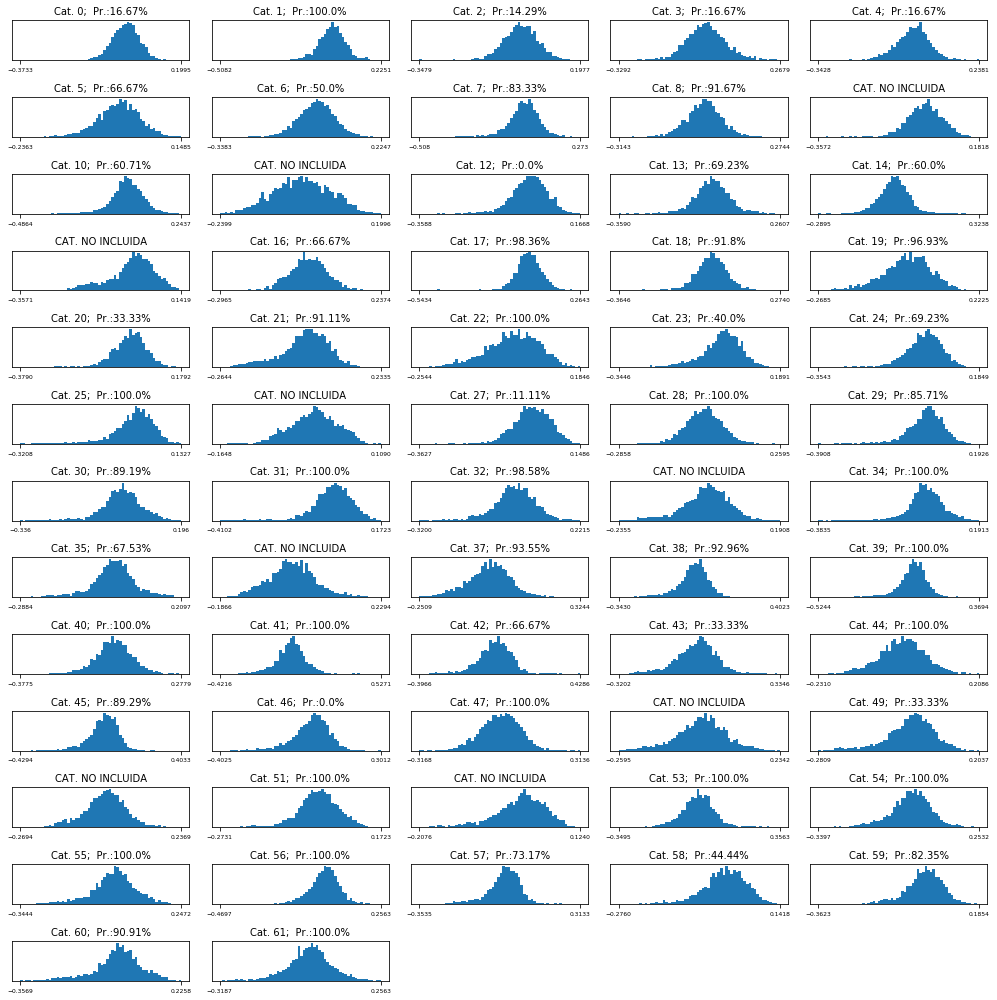

In [72]:
 display_histograms_test(m2_weights, titles_aciertos_hist)